In [2]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib
from tqdm.notebook import tqdm

from topostats.filters import Filters
from topostats.grains import Grains
from topostats.grainstats import GrainStats
from topostats.io import find_files, read_yaml, write_yaml, LoadScans
from topostats.logs.logs import setup_logger, LOGGER_NAME
from topostats.utils import update_config

[Wed, 18 Oct 2023 07:53:28] [INFO    ] [topostats] Extracting image from C:\Users\obataya\GitHub-repo\line_detection\data\polymer.gwy
[Wed, 18 Oct 2023 07:53:28] [INFO    ] [topostats] Loading image from : C:\Users\obataya\GitHub-repo\line_detection\data\polymer.gwy
[Wed, 18 Oct 2023 07:53:28] [INFO    ] [topostats] 	(polymer) has a topography image with z-height data(m).
[Wed, 18 Oct 2023 07:53:28] [INFO    ] [topostats] [polymer] Image added to processing.
Shape of image data: (320, 240)
Available keys: dict_keys(['filename', 'channel', 'img_path', 'pixel_to_nm_scaling', 'image_original', 'image_flattened', 'grain_masks', 'scale'])


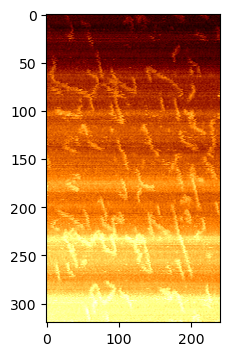

In [2]:
# Set BASE_DIR containing a file and config.yaml
BASE_DIR=Path(os.getenv('REPO')).joinpath('line_detection').joinpath('data')
FILE_EXT = ".gwy"
IMG_FILES = [BASE_DIR.joinpath('polymer.gwy'),]
IMG_KEY = "polymer"

config = read_yaml(BASE_DIR.joinpath("polymer_config.yaml"))
#print(json.dumps(config, indent=4)) # print json dump
loading_config = config["loading"]
filter_config = config["filter"]
filter_config.pop("run")
grain_config = config["grains"]
grain_config.pop("run")
loaded_data = LoadScans(IMG_FILES, **config["loading"])
loaded_data.get_data()

print(f"Shape of image data: {np.shape(loaded_data.image)}")
print(f"Available keys: {loaded_data.img_dict[IMG_KEY].keys()}")
# Plot the loaded scan in its raw format
fig, ax = plt.subplots(figsize=(4, 4))
# When Topostats loads .gwy file, aspect ratio of the image is in img_dict.
plt.imshow(loaded_data.image, cmap="afmhot", aspect=loaded_data.img_dict[IMG_KEY]["scale"]["xy_aspect"])
plt.show()

In [3]:
# Filter
filtered_image = Filters(
        image=loaded_data.img_dict[IMG_KEY]["image_original"],
        filename=loaded_data.img_dict[IMG_KEY]["img_path"],
        pixel_to_nm_scaling=loaded_data.img_dict[IMG_KEY]["pixel_to_nm_scaling"],
        **filter_config,)
filtered_image.filter_image()

[Wed, 18 Oct 2023 07:53:41] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Median flattening without mask
[Wed, 18 Oct 2023 07:53:41] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Plane tilt removal without mask
[Wed, 18 Oct 2023 07:53:41] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : x-polyfit 1st order: [-0.00066365  0.07657334]
[Wed, 18 Oct 2023 07:53:41] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : y-polyfit 1st order: [ 1.15611775e-17 -2.24368810e-15]
[Wed, 18 Oct 2023 07:53:41] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Removing x plane tilt
[Wed, 18 Oct 2023 07:53:41] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : removing y plane tilt
[Wed, 18 Oct 2023 07:53:41] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Remove 

Available NumPy arrays to plot in filter_image.images dictionary :

dict_keys(['pixels', 'initial_median_flatten', 'initial_tilt_removal', 'initial_quadratic_removal', 'initial_scar_removal', 'masked_median_flatten', 'masked_tilt_removal', 'masked_quadratic_removal', 'secondary_scar_removal', 'scar_mask', 'mask', 'zero_average_background', 'gaussian_filtered', 'initial_nonlinear_polynomial_removal', 'masked_nonlinear_polynomial_removal'])


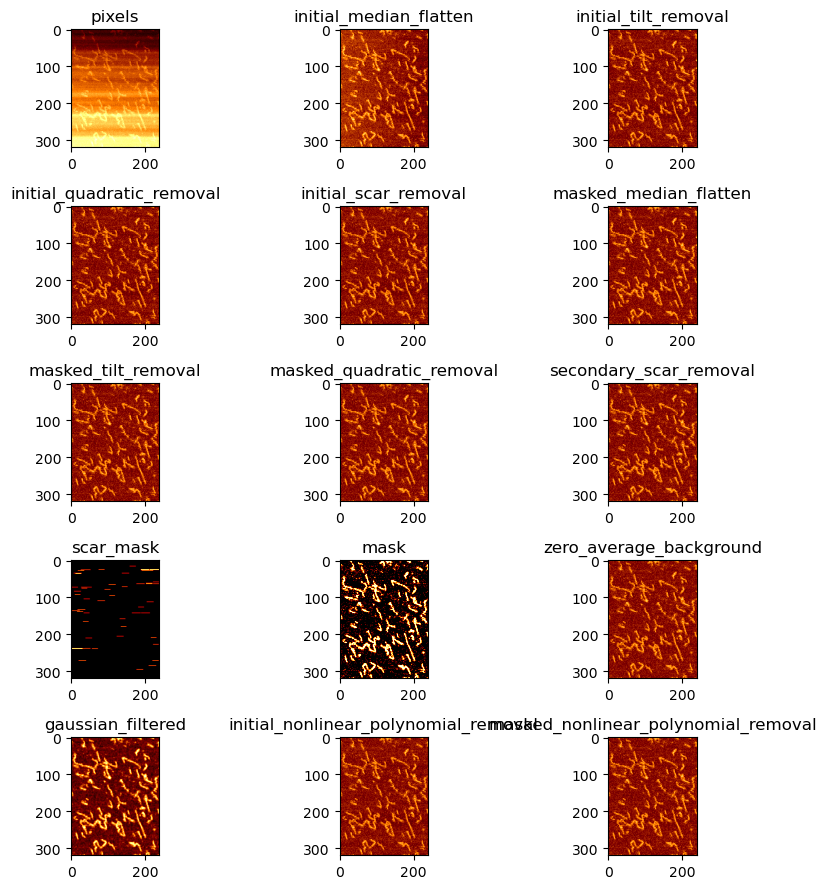

In [4]:
# image tiler
def tile_all_images(image_dict, cols):
    key_list = list(image_dict.keys())
    key_count = len(key_list)
    
    rows = int((key_count - key_count % cols) / cols)

    fig, ax = plt.subplots(rows,cols,figsize=(9,9))
    idx = 0
    for row in range(rows):
        for col in range(cols):
            key = key_list[idx]
            if image_dict[key] is None:
                continue
            ax[row,col].set_title(key)
            ax[row,col].imshow(image_dict[key], cmap="afmhot")
            idx += 1
            if idx == key_count:
                break
        if idx == key_count:
            break
    fig.tight_layout()
    plt.show()

SHOW_TILE = True
if SHOW_TILE:
    print(f"Available NumPy arrays to plot in filter_image.images dictionary :\n\n{filtered_image.images.keys()}")
    tile_all_images(filtered_image.images,3)

# Find grains

Here polymer chains are detected by using Grains of Topostats. Resulting Numpy array of "labelled_regions_02" conatins index label starting with 1 for all polymer chains. 

In [5]:
try:
    labelled
except NameError:
    grains = Grains(
                image=filtered_image.images["zero_average_background"],
                filename=filtered_image.filename,
                pixel_to_nm_scaling=filtered_image.pixel_to_nm_scaling,
                **grain_config,
                )
    grains.find_grains()
    labelled = grains.directions["above"]["labelled_regions_02"]
print(f"Resulting image keys above threshold:\n {grains.directions['above'].keys()}")
print(f"Resuting labelled image of polymer chains:\n count {labelled.max()}, type {type(labelled)}, shape {labelled.shape}")

[Wed, 18 Oct 2023 07:53:53] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Thresholding method (grains) : otsu
[Wed, 18 Oct 2023 07:53:53] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Finding above grains, threshold: (0.18092139420524733)
[Wed, 18 Oct 2023 07:53:53] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Masking (above) Threshold: 0.18092139420524733
[Wed, 18 Oct 2023 07:53:53] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Labelling Regions
[Wed, 18 Oct 2023 07:53:53] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Tidying borders
[Wed, 18 Oct 2023 07:53:53] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Removing noise (above)
[Wed, 18 Oct 2023 07:53:53] [INFO    ] [topostats] [C:\Users\obataya\GitHub-repo\line_detection\data\polymer] : Area thresholding gra

# Line detection
Linemol module is for detection of linear part of polymer chain of SPM height data. Principle of this analysis is to score all possible lines in a molecule. The score is calculated from the sum of the height values of the pixels that make up the line.

## Data import and filtering by Topostats
Topostats is a Python library for topological data analysis. It provides a set of tools for analyzing and visualizing topological data, such as persistent homology, persistent diagrams, and other related techniques. It is designed to be easy to use and extend, and is suitable for both research and educational purposes. Filtering and finding grains from a Gwyddion file are conducted by Topostats software program. 

## Molecule class
Pixels of each molecule are obtained from grains.directions["above"]["labelled_regions_02"]. A class of `LineDetection` handles the labelled regions ndarray. All molecules are stored as `Molecule` object that provide positions, vectors generated from the positions, methods for detection of linear part.

## Processing
Number of all possible vectors in a molecule sometimes comes enormous, so several steps are implemented to reduce unnecessary lines.

### Qudrants and length filtering
vector pairs are filtered by direction and length. The minimum and maximum length are defined as `min_len` and `max_len` in a config dict.
-  Exclude vectors from the set that are facing the third and fourth quadrants.
-  Exclude vectors exceeding provided minimum and maximum length

### Empty pixel(s) along a line
After collecting the set of vectors, a synthetic straight line is drawn in 2D binary array. When original binary data has gaps along the synthetic line, it is considered to have 'empty' pixels. A line with large number of empty pixels are excluded because it should not be regard as a straight and continuous line. The maximum pixel number is defined as `allowed_empty` in a config dict.

Resulting lines are stored as DataFrame of pandas. Initial dataframe has columns of `mol_idx`, `score`, `pix1`, `pix2`, `angle`, `overlapped`.

### Overlapping lines
Some lines are covered with a longer line completely, others are covered partially. Shorter and lines with lower score that is covered with other line can be eliminated. In order to prioritize score, dataframe was sorted descending by `score` column.



In [3]:
# assuming linedetection.py is in parent directory of data 
#MOD_DIR=Path(os.getenv('REPO')).joinpath('line_detection')
#sys.path.append(MOD_DIR)
import linemol
importlib.reload(linemol)

from linemol import Molecule, LineDetection


In [4]:
    labelled_img = np.array([
        [0,0,0,0,1,1,0,0],
        [1,0,1,1,0,0,0,0],
        [1,1,0,2,2,0,2,2],
        [0,0,0,0,0,2,0,0]])
    source_img = np.array([
        [0,0,0,0,3,4,0,0],
        [0,0,5,2,0,0,0,0],
        [8,8,0,4,5,0,4,3],
        [0,0,0,0,0,4,0,0]])

    config = {"min_len":1,"max_len":100,"allowed_empty":0}
    ld = LineDetection(labelled_img, source_img, **config)

In [5]:
print(ld)

Line detection object: 2 molecules.


In [8]:
mol = ld.molecules[1]
print("raw data")
print(mol.yxT)

matrix = mol.get_displacement_matrix()
print("displacement")
print(LineDetection._matrix_table(matrix))

raw data
[[0 0]
 [0 1]
 [0 3]
 [0 4]
 [1 2]]
displacement
[0 0]  	[0 1]  	[0 3]  	[0 4]  	[1 2]  
[ 0 -1]	[0 0]  	[0 2]  	[0 3]  	[1 1]  
[ 0 -3]	[ 0 -2]	[0 0]  	[0 1]  	[ 1 -1]
[ 0 -4]	[ 0 -3]	[ 0 -1]	[0 0]  	[ 1 -2]
[-1 -2]	[-1 -1]	[-1  1]	[-1  2]	[0 0]  


In [9]:
vec_pairs = mol.get_vector_pairs()
print(vec_pairs)

[[  0.           1.           1.           0.        ]
 [  0.           2.           3.           0.        ]
 [  0.           3.           4.           0.        ]
 [  0.           4.           2.23606798  26.56505118]
 [  1.           2.           2.           0.        ]
 [  1.           3.           3.           0.        ]
 [  1.           4.           1.41421356  45.        ]
 [  2.           3.           1.           0.        ]
 [  2.           4.           1.41421356 135.        ]
 [  3.           4.           2.23606798 153.43494882]]


In [10]:
np.where((vec_pairs>3))

(array([2, 3, 3, 6, 6, 8, 8, 9, 9], dtype=int64),
 array([2, 1, 3, 1, 3, 1, 3, 1, 3], dtype=int64))

In [83]:
np.rad2deg(np.arctan2(1.732,1))

59.999272219172624

In [11]:
source_img = filtered_image.images["gaussian_filtered"]
linemol = LineDetection(labelled,source_img)
count = len(linemol.molecules)
print(f"{count} molecules are stored in molecules list.")



58 molecules are stored in molecules list.


1230 pixels in the molecule. All combinations of vecor: 755835


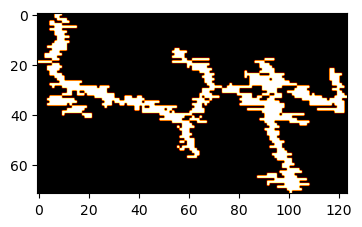

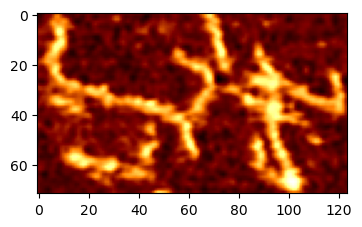

In [14]:
def plot_image(image, aspect = 1.0):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.imshow(image, cmap="afmhot", aspect=aspect)
    plt.show()
    
mol_idx = 8
mol = linemol.molecules[mol_idx]
pixel_count = mol.count()
combinations = pixel_count * (pixel_count - 1) // 2
print(f"{pixel_count} pixels in the molecule. All combinations of vecor: {combinations}")
plot_image(mol.get_mask())
plot_image(mol.src_img)

In [15]:
mol.count()

1230

# Filter all possible lines
Line detection will trace all possible lines, that are filtered by length and quadrant of its vector.

In [18]:
(min_len, max_len) = (10, 50)
filtered_matrix = mol.filter_by_length(min_length=min_len,  max_length=max_len)
(vector_ar,mask)= filtered_matrix
print(f"{len(vector_ar[0])} vectors (pixel pairs), length range from {min_len} to {max_len}")
#type(mol.origin_mask)

401335 vectors (pixel pairs), length range from 10 to 50


In [12]:
# Collect results in lists.
allowed_empty = 0

score_list = []
pix_id1s = []
pix_id2s = []
angles = []
(pix_id1,pix_id2) = (vector_ar[0],vector_ar[1])
vec_count = len(pix_id1)
all_lines = mol.get_blank_image()

score_max = 0
score_max_line_image = None

for i in tqdm(range(0,vec_count)):
    score_result = mol.score_line(vector_ar, i, allowed_empty=0)
    if score_result == None:
        continue
    (score, line_mask) = score_result
    score_list.append(score)
    (pid1, pid2) = mol.get_pix_id_pair(vector_ar, i)
    pix_id1s.append(pid1)
    pix_id2s.append(pid2)
    (dy, dx) = mol.get_displacement_vector(pid1, pid2)
    if dy < 0:
        (dy, dx) = (-dy, -dx)
    angle = np.degrees(np.arctan2(dy,dx))
    angles.append(angle)

  0%|          | 0/311188 [00:00<?, ?it/s]

In [58]:
import pandas as pd
data = {"score":score_list,"pix1":pix_id1s,"pix2":pix_id2s,"angle":angles, "overlapped":False}
df = pd.DataFrame(data)
df.sort_values("score",ascending=False, inplace=True) # sorting score in place
df.reset_index(inplace=True, drop=True) # re-indexing in place
df["r_angle"] = df["angle"] - (df["angle"] % 5.0)

In [59]:
df.head()

,score,pix1,pix2,angle,overlapped,r_angle
0,14.330488,688,1226,69.623565,False,65.0
1,13.836651,688,1221,69.075498,False,65.0
2,13.821294,750,1220,71.565051,False,70.0
3,13.804514,795,1226,70.016893,False,70.0
4,13.468191,795,1220,71.029592,False,70.0


In [67]:
df.at[0,"overlapped"] = True

In [68]:
df.iloc[0].to_dict()

{'score': 14.33048813081983,
 'pix1': 688,
 'pix2': 1226,
 'angle': 69.62356478616361,
 'overlapped': True,
 'r_angle': 65.0}

# Sort後のndarrayを使う

ソートした後なら、オーバーラップしつつより短いものが後に続く。




In [69]:
#result = mol.src_img.copy()
row_count = df.shape[0]
result = mol.get_blank_image()
line_count = 0
high_scored_lines = []
high_scored_angle = []
for i in range(row_count):
    items = df.iloc[i].to_dict()
    (pix1, pix2) = (items["pix1"], items["pix2"])
    angle = items["angle"]
    (y1, x1) = mol.get_yx(pix1)
    (y2, x2) = mol.get_yx(pix2)
    line_mask = mol.get_line_mask(pix1, pix2)
    overlapped = False
    for j in range(len(high_scored_lines)):
        line = high_scored_lines[j]
        overlap_mask = line_mask * line
        if overlap_mask.sum() > 3:
            overlapped = True
            df.at[i,"overlapped"] = True
            break
    if not overlapped:
        result = result + line_mask
        high_scored_lines.append(line_mask)
        high_scored_angle.append(angle)
        line_count += 1
#        if line_count > 100:
#            break
#print(high_scored_angle, line_count)
print(f"line : {line_count}")

line : 136


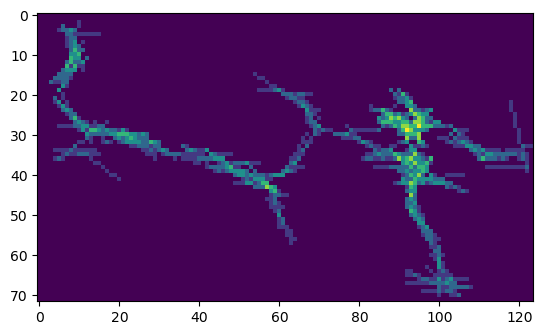

In [70]:
plt.imshow(result)

array([[<AxesSubplot:title={'center':'angle'}>]], dtype=object)

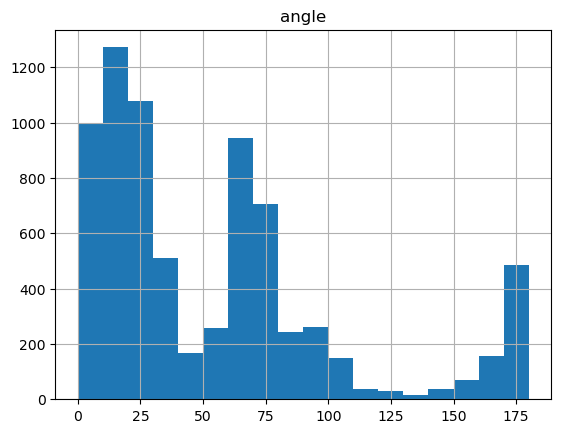

In [72]:
df.hist("angle", bins=18)

(array([14.,  8., 11., 21., 12., 13.,  6.,  5.,  4.,  3.,  3.,  2.,  9.,
         3.,  5.,  1.,  6., 10.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180.]),
 <BarContainer object of 18 artists>)

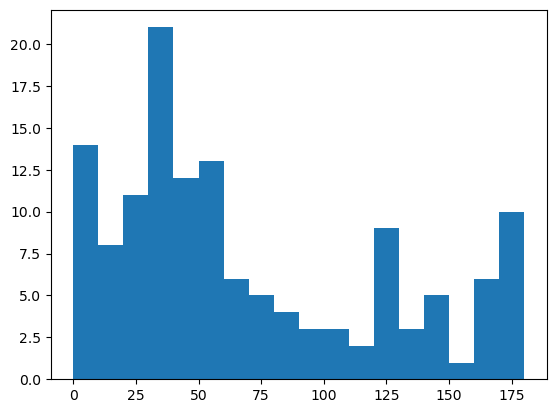

In [73]:
plt.hist(high_scored_angle,bins=18)

In [80]:
hoge = pd.DataFrame(columns=["c1","c2"])


In [81]:
hoge

,c1,c2


In [82]:
hoge.append([10,20])

,c1,c2,0
0,NaN,NaN,10.0
1,NaN,NaN,20.0


In [83]:
data = {"c1":[10],"c2":[20]}
hoge.append(data)

TypeError: Can only append a dict if ignore_index=True

In [84]:
hoge = {}
hoge["hoge"][1][3] = 10
hoge

KeyError: 'hoge'